In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua


In [2]:
def get_adj(station, tarvar):
    import datetime
    if tarvar == 'directionbias':
        cdsvar = 'wind_direction'
    elif tarvar == 'uwindbias':
        cdsvar = 'u_component_of_wind'
    elif tarvar == 'vwindbias':
        cdsvar = 'v_component_of_wind'
    else:
        print('not an available wind variable')
        return 0, 0, 0, 0, 0
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    file = glob.glob('./Wind_adjustment/*/*winddir*'+station+'*')[0]
    data = eua.CDMDataset(file)#.to_dataframe()
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    adjdates = []
    basedatum = data.datum[:]
    for i in basedatum:
        adjdates.append(date0 + datetime.timedelta(days=int(i)))
    dates = adjdates
    
    press = data.press[:]
    nightadj = data[tarvar][0,:]
    dayadj = data[tarvar][1,:]    
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': cdsvar,
                    'optional':['wind_bias_estimate'],
                    'statid': station,
                    'skipaa':'8f874f4f',
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/wind/cds_' + station + '/' + cdsvar)
    z.close()
    cdsfile = glob.glob('./tocompare/wind/cds_' + station + '/' + cdsvar + '/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daycdsdata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightcdsdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
        
    for j in range(len(press)):
        try:
            d_adjd = dayadj[j]
            calc_day_out[str(int(press[j]))].append(d_adjd)
        except:
            calc_day_out[str(int(press[j]))].append(np.nan) 
        try:
            n_adjd = nightadj[j]
            calc_night_out[str(int(press[j]))].append(n_adjd)
        except:
            calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, daycdsdata, nightcdsdata, calc_day_out, calc_night_out

In [3]:
def plt_adj(dates, cdata, adata, plev, station, time, adj, save):
#     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    ax.scatter(cdata.time, cdata.wind_bias_estimate, label='CDS', s=50)
    ax.scatter(dates, np.asarray(adata[str(plev)]), label='Calc', s=20)
    ax.set(xlabel='time', ylabel='Adjustment: '+adj,
           title= str(station)+' Wind '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Wind_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

2021-05-06 10:54:44,690 INFO Welcome to the CDS
2021-05-06 10:54:44,692 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:54:45,088 INFO Request is completed
2021-05-06 10:54:45,090 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620290969.8535511-7857-1-2c7b9a67-2c14-4d57-bce4-b1dc5dce284d.zip to download.zip (10.5M)
2021-05-06 10:54:46,249 INFO Download rate 9.1M/s   
2021-05-06 10:54:46,355 INFO Reading Profile on slice(None, None, None)
2021-05-06 10:54:47,920 INFO Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-05-06 10:54:47,922 INFO NumExpr defaulting to 8 threads.


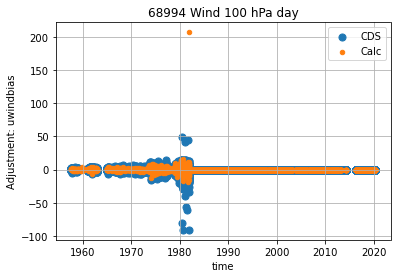

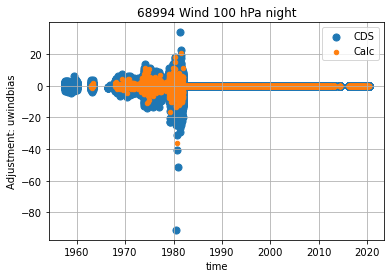

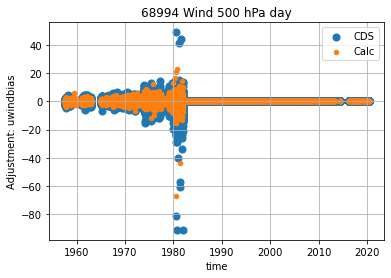

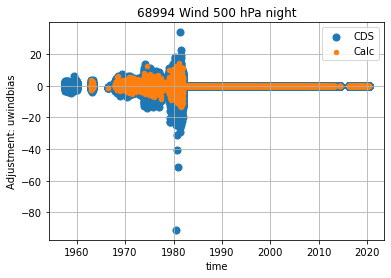

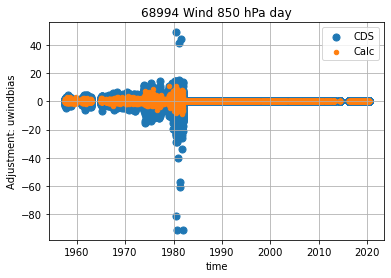

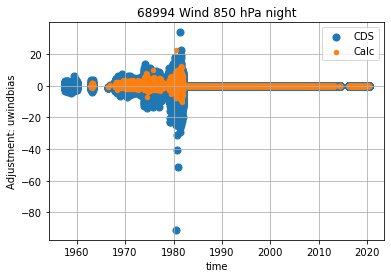

In [4]:
station = '68994'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 10:55:05,564 INFO Welcome to the CDS
2021-05-06 10:55:05,565 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:55:05,736 INFO Request is completed
2021-05-06 10:55:05,736 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620290995.6615684-7928-1-83cc478f-3f2b-42b6-90f5-9efce8c2e550.zip to download.zip (10.6M)
2021-05-06 10:55:06,932 INFO Download rate 8.8M/s   
2021-05-06 10:55:07,044 INFO Reading Profile on slice(None, None, None)


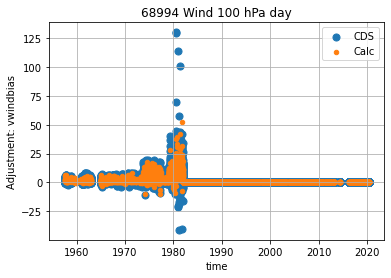

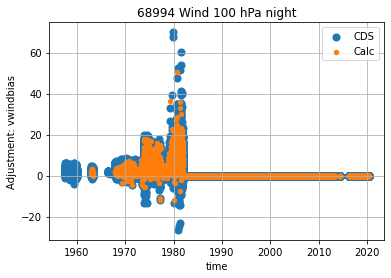

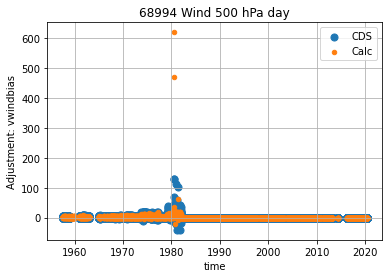

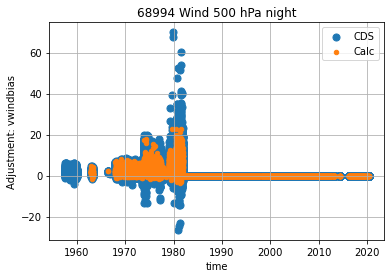

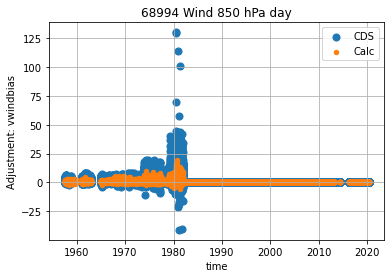

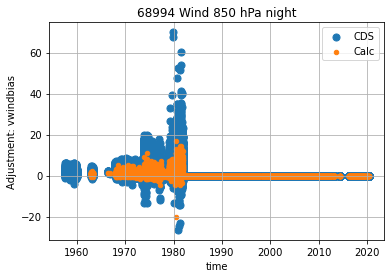

In [5]:
station = '68994'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 10:55:27,191 INFO Welcome to the CDS
2021-05-06 10:55:27,192 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:55:27,363 INFO Request is completed
2021-05-06 10:55:27,364 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291028.911038-8219-1-74795e3f-3def-49d0-b7ef-3be0ebe99370.zip to download.zip (9.7M)
2021-05-06 10:55:28,514 INFO Download rate 8.5M/s   
2021-05-06 10:55:28,591 INFO Reading Profile on slice(None, None, None)


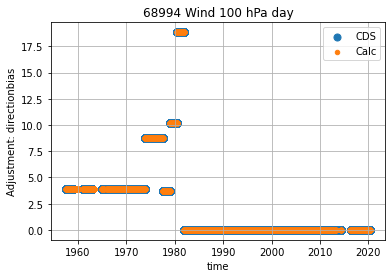

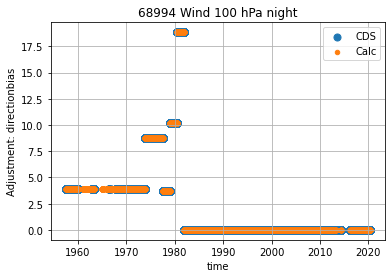

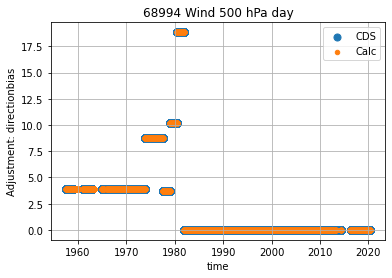

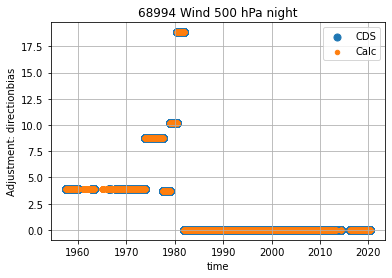

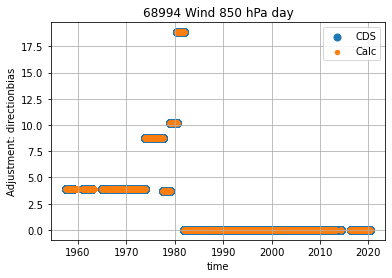

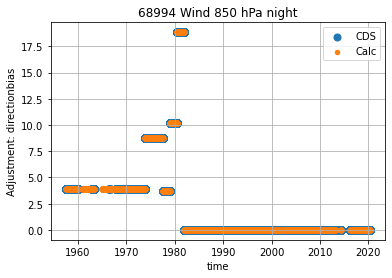

In [6]:
station = '68994'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

2021-05-06 10:55:47,363 INFO Welcome to the CDS
2021-05-06 10:55:47,364 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:55:47,590 INFO Request is completed
2021-05-06 10:55:47,592 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620290257.927852-475-9-88f4771c-6651-4e78-8338-e7755110d644.zip to download.zip (10.7M)
2021-05-06 10:55:48,783 INFO Download rate 9M/s     
2021-05-06 10:55:48,888 INFO Reading Profile on slice(None, None, None)


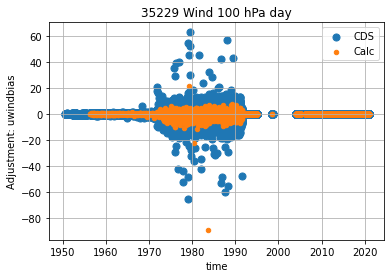

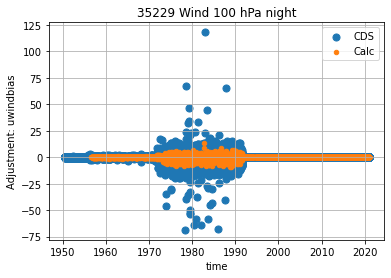

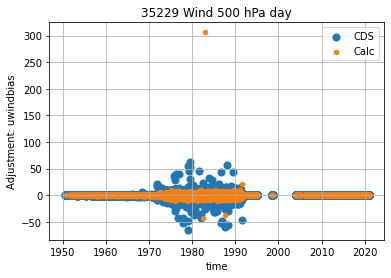

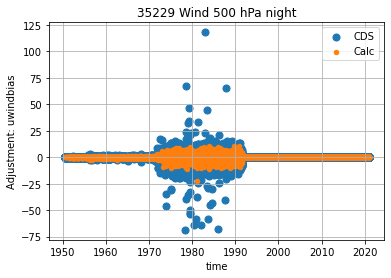

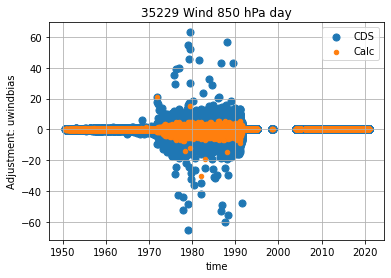

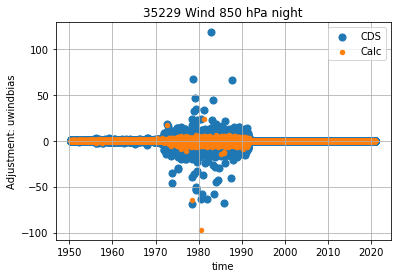

In [7]:
station = '35229'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 10:56:21,636 INFO Welcome to the CDS
2021-05-06 10:56:21,637 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:56:21,953 INFO Request is completed
2021-05-06 10:56:21,954 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291079.9912765-8141-1-8433c84a-eb1b-438d-9f63-10fbc584f0f5.zip to download.zip (10.7M)
2021-05-06 10:56:23,314 INFO Download rate 7.9M/s   
2021-05-06 10:56:23,393 INFO Reading Profile on slice(None, None, None)


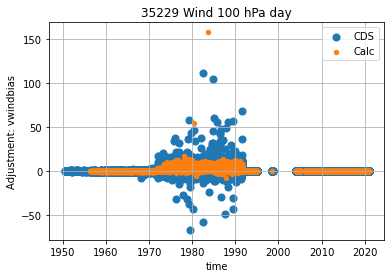

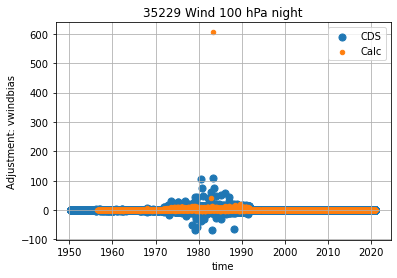

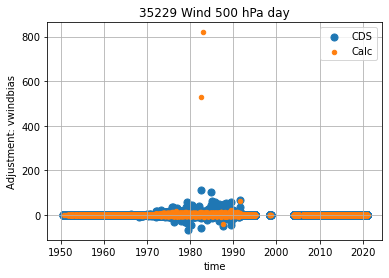

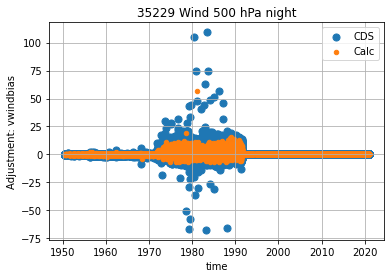

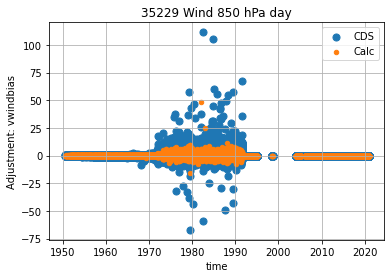

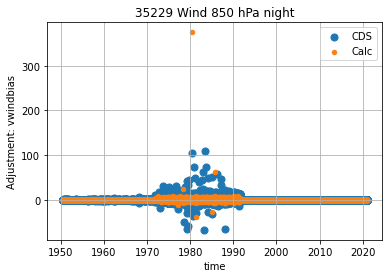

In [8]:
station = '35229'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 10:56:47,687 INFO Welcome to the CDS
2021-05-06 10:56:47,688 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:56:47,893 INFO Request is completed
2021-05-06 10:56:47,894 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620290149.3194213-309-9-318a5718-3697-4524-a855-79788aeb0a4f.zip to download.zip (9.3M)
2021-05-06 10:56:49,105 INFO Download rate 7.6M/s   
2021-05-06 10:56:49,226 INFO Reading Profile on slice(None, None, None)


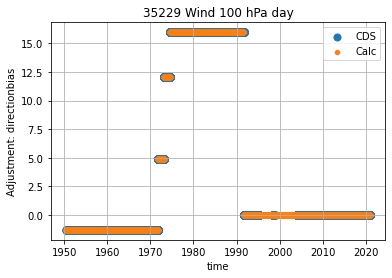

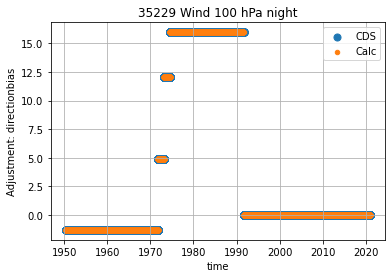

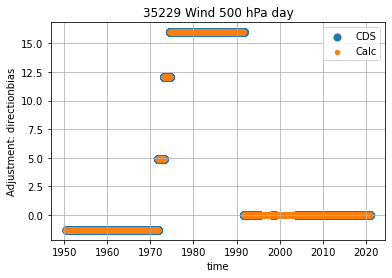

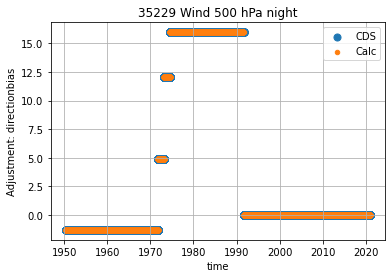

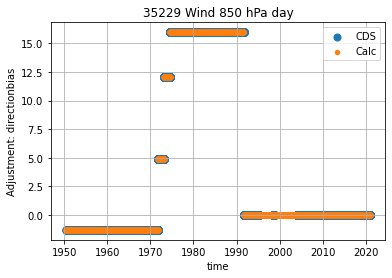

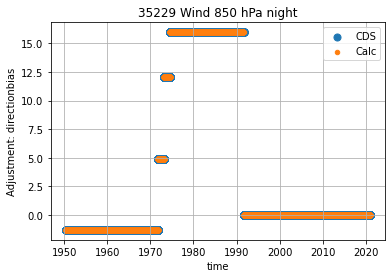

In [9]:
station = '35229'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

2021-05-06 10:57:10,980 INFO Welcome to the CDS
2021-05-06 10:57:10,981 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:57:11,144 INFO Request is queued
2021-05-06 10:57:12,182 INFO Request is running
2021-05-06 10:57:16,006 INFO Request is completed
2021-05-06 10:57:16,007 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291434.1379716-8084-1-780f064f-e79f-415f-aa16-be46e848ebf2.zip to download.zip (22.7M)
2021-05-06 10:57:24,102 INFO Download rate 2.8M/s     
2021-05-06 10:57:24,329 INFO Reading Profile on slice(None, None, None)


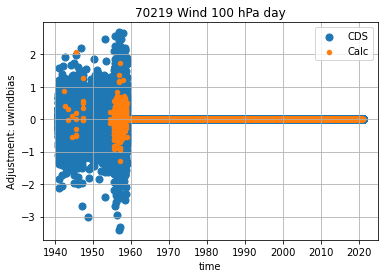

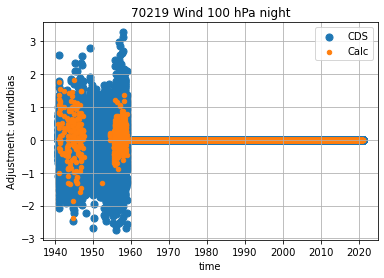

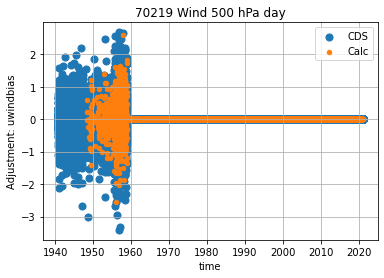

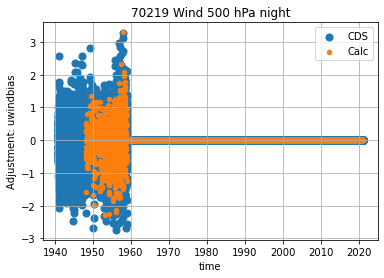

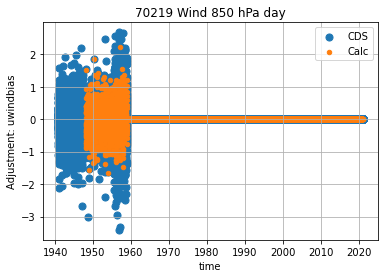

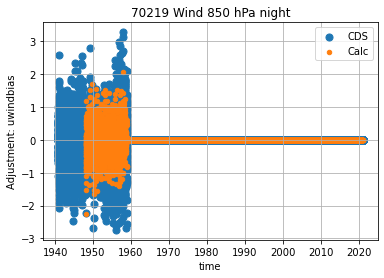

In [10]:
station = '70219'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 10:58:00,430 INFO Welcome to the CDS
2021-05-06 10:58:00,431 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:58:00,828 INFO Request is queued
2021-05-06 10:58:01,867 INFO Request is running
2021-05-06 10:58:05,690 INFO Request is completed
2021-05-06 10:58:05,691 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291483.78808-8295-1-467fab98-5990-4441-814d-0dc5b3d0502f.zip to download.zip (22.7M)
2021-05-06 10:58:09,844 INFO Download rate 5.5M/s   
2021-05-06 10:58:10,105 INFO Reading Profile on slice(None, None, None)


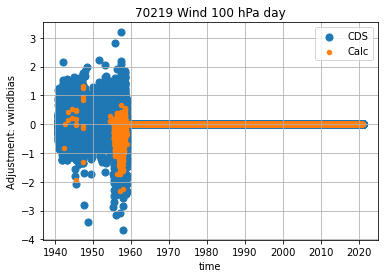

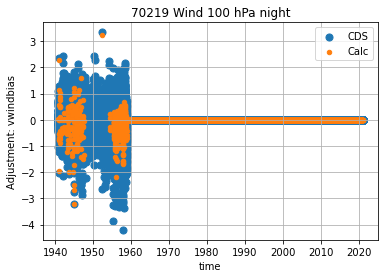

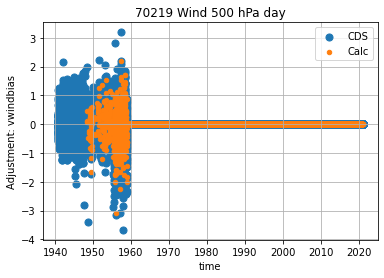

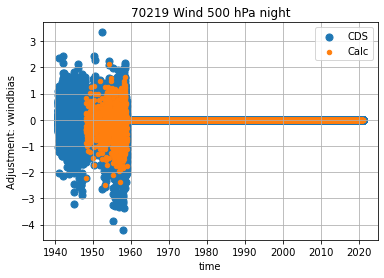

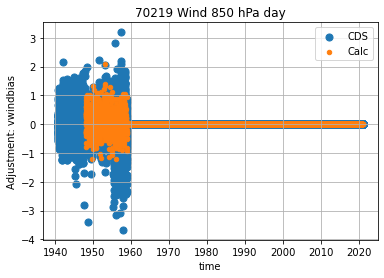

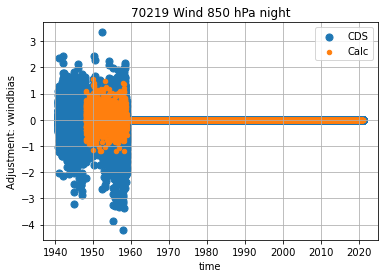

In [11]:
station = '70219'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 10:59:01,001 INFO Welcome to the CDS
2021-05-06 10:59:01,002 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:59:01,343 INFO Request is queued
2021-05-06 10:59:02,382 INFO Request is running
2021-05-06 10:59:06,213 INFO Request is completed
2021-05-06 10:59:06,216 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291544.1432052-8264-1-0777ac69-1b25-4842-8126-0da627d166ec.zip to download.zip (21.9M)
2021-05-06 10:59:10,078 INFO Download rate 5.7M/s   
2021-05-06 10:59:10,386 INFO Reading Profile on slice(None, None, None)


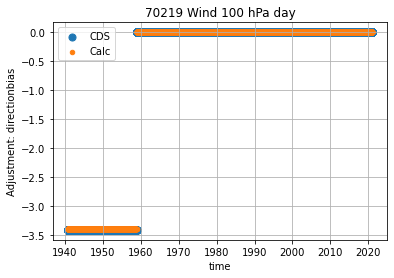

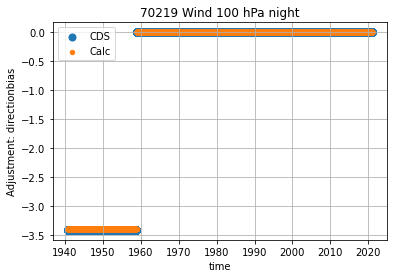

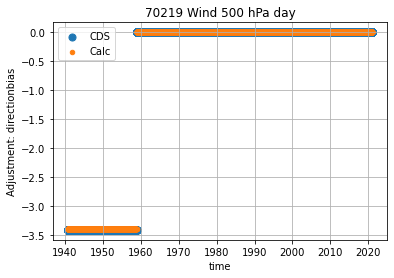

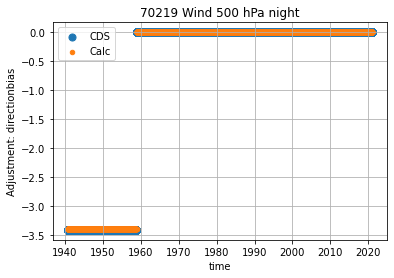

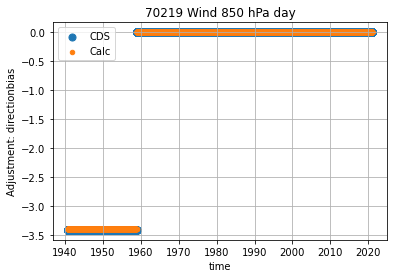

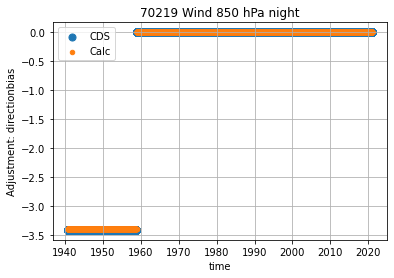

In [12]:
station = '70219'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

2021-05-06 10:59:50,647 INFO Welcome to the CDS
2021-05-06 10:59:50,648 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 10:59:50,857 INFO Request is queued
2021-05-06 10:59:51,896 INFO Request is running
2021-05-06 11:00:05,812 INFO Request is completed
2021-05-06 11:00:05,813 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291602.6545684-7890-1-463c7f55-0c5b-4f0c-bb53-b9cd92f92ccd.zip to download.zip (32.3M)
2021-05-06 11:00:10,153 INFO Download rate 7.4M/s   
2021-05-06 11:00:10,342 INFO Reading Profile on slice(None, None, None)


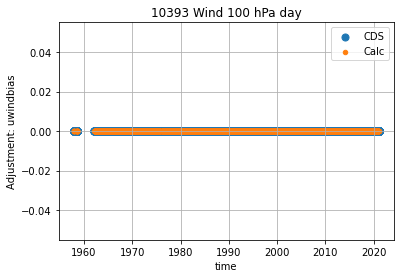

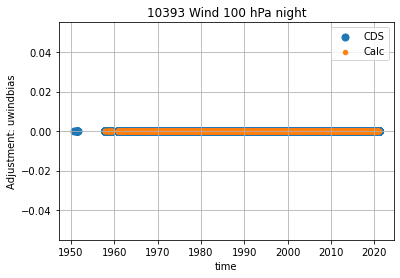

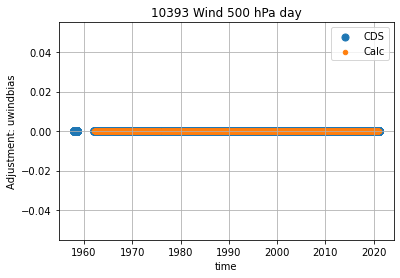

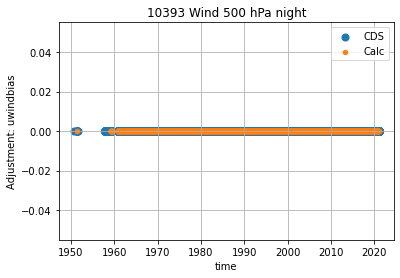

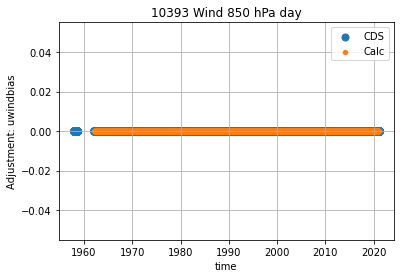

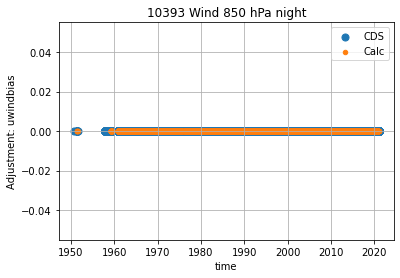

In [13]:
station = '10393'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 11:00:49,720 INFO Welcome to the CDS
2021-05-06 11:00:49,723 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 11:00:50,082 INFO Request is queued
2021-05-06 11:00:51,122 INFO Request is running
2021-05-06 11:01:03,457 INFO Request is completed
2021-05-06 11:01:03,543 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291661.6672518-8045-1-fdc5f8ca-e058-4efd-a34f-461f1bcaae64.zip to download.zip (32.3M)
2021-05-06 11:01:08,640 INFO Download rate 6.3M/s   
2021-05-06 11:01:09,242 INFO Reading Profile on slice(None, None, None)


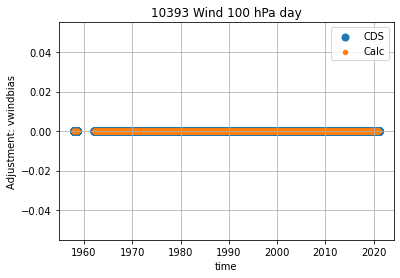

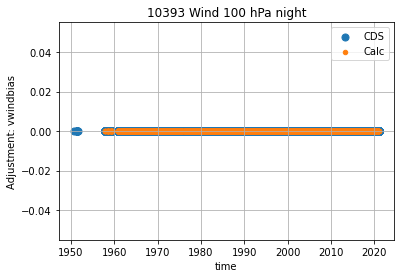

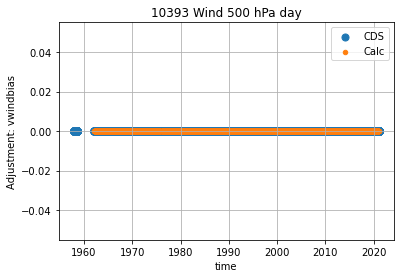

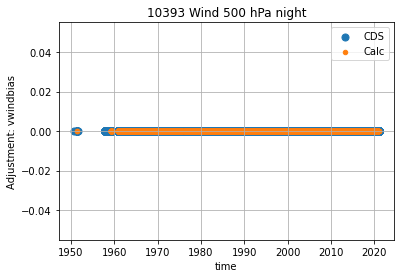

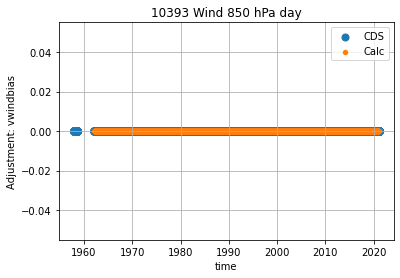

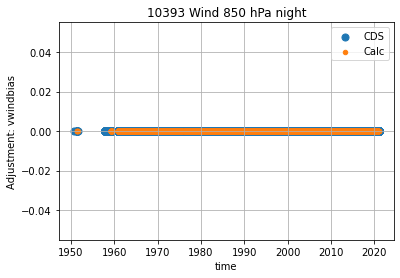

In [14]:
station = '10393'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 11:01:48,043 INFO Welcome to the CDS
2021-05-06 11:01:48,044 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 11:01:48,354 INFO Request is queued
2021-05-06 11:01:49,391 INFO Request is running
2021-05-06 11:02:01,731 INFO Request is completed
2021-05-06 11:02:01,732 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291719.5413384-8468-1-78106644-7459-4993-b222-48ecd8f1a9d8.zip to download.zip (31.1M)
2021-05-06 11:02:08,353 INFO Download rate 4.7M/s     
2021-05-06 11:02:08,835 INFO Reading Profile on slice(None, None, None)


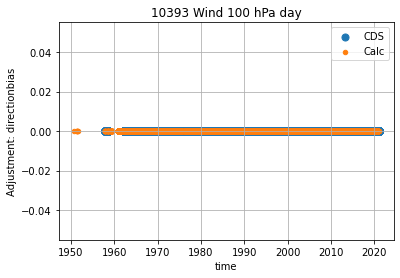

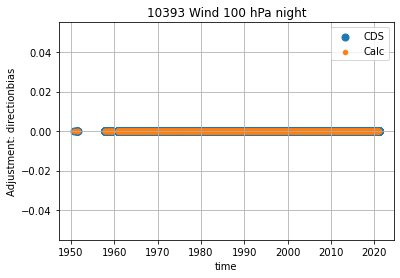

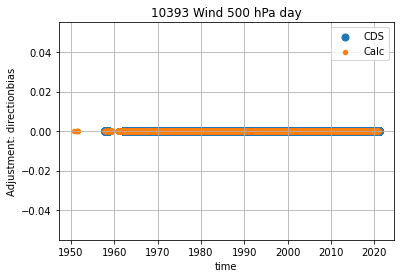

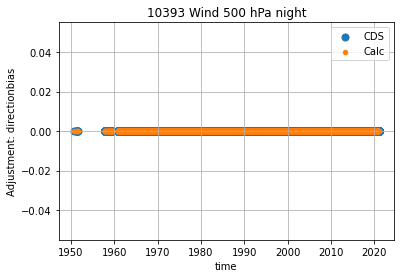

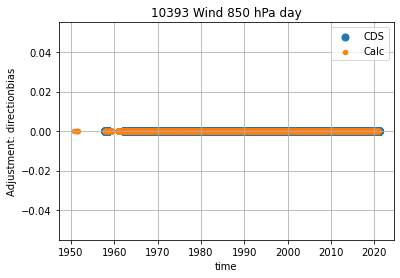

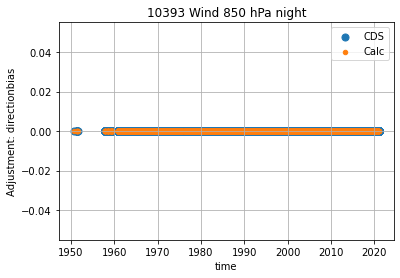

In [15]:
station = '10393'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

2021-05-06 11:02:48,889 INFO Welcome to the CDS
2021-05-06 11:02:48,890 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 11:02:49,283 INFO Request is queued
2021-05-06 11:02:50,324 INFO Request is running
2021-05-06 11:02:54,177 INFO Request is completed
2021-05-06 11:02:54,178 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291773.0848098-8402-1-f795fcda-77ac-4094-9ae8-d34b446b0f63.zip to download.zip (35.8M)
2021-05-06 11:03:06,604 INFO Download rate 2.9M/s     
2021-05-06 11:03:07,050 INFO Reading Profile on slice(None, None, None)


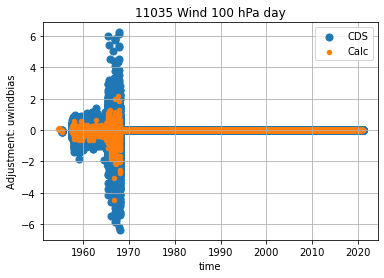

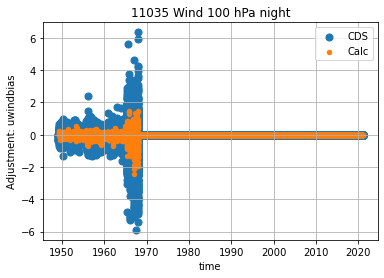

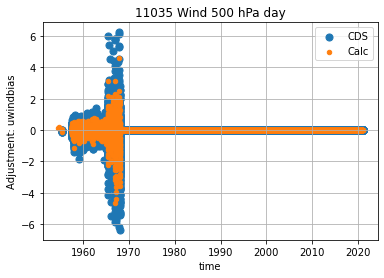

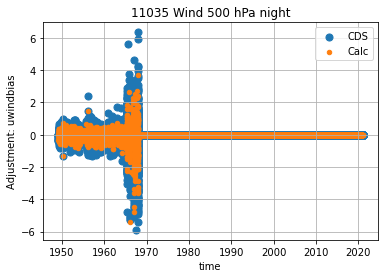

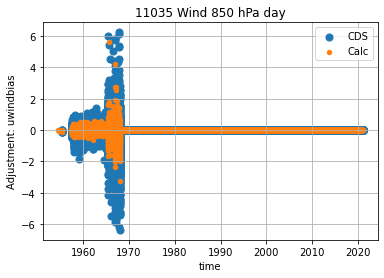

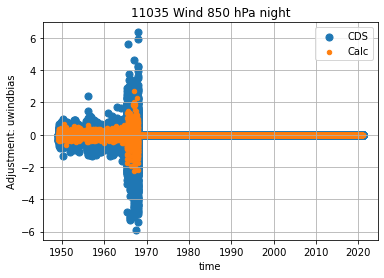

In [16]:
station = '11035'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 11:03:46,856 INFO Welcome to the CDS
2021-05-06 11:03:46,858 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 11:03:47,181 INFO Request is queued
2021-05-06 11:03:48,223 INFO Request is running
2021-05-06 11:03:52,050 INFO Request is completed
2021-05-06 11:03:52,052 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291830.7591286-8596-1-44e3579a-c57d-41e5-bbcc-3f5f2a4c4b7a.zip to download.zip (35.8M)
2021-05-06 11:04:05,075 INFO Download rate 2.7M/s     
2021-05-06 11:04:05,537 INFO Reading Profile on slice(None, None, None)


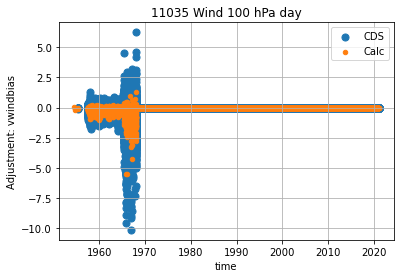

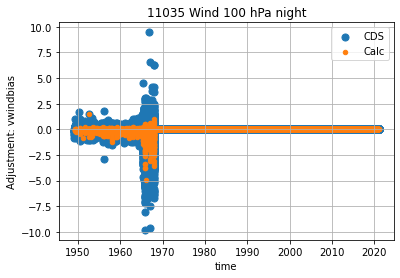

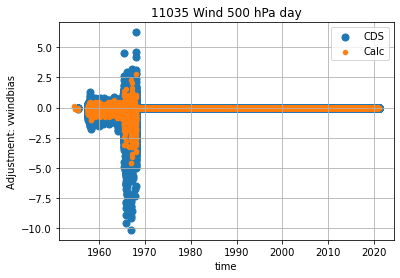

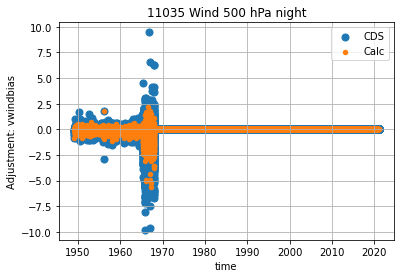

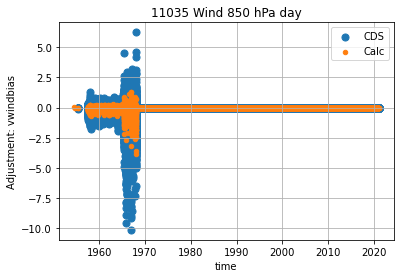

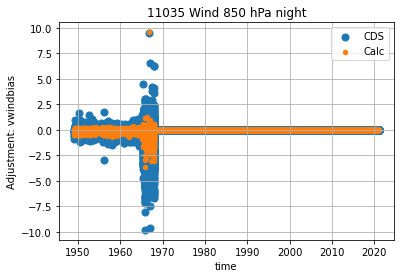

In [17]:
station = '11035'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 11:04:50,437 INFO Welcome to the CDS
2021-05-06 11:04:50,439 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 11:04:50,808 INFO Request is queued
2021-05-06 11:04:51,845 INFO Request is running
2021-05-06 11:04:55,667 INFO Request is completed
2021-05-06 11:04:55,668 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291894.3266828-8326-1-bca85f88-0fc8-4762-9d11-3b0b1549c3ab.zip to download.zip (34.5M)
2021-05-06 11:05:06,370 INFO Download rate 3.2M/s     
2021-05-06 11:05:06,866 INFO Reading Profile on slice(None, None, None)


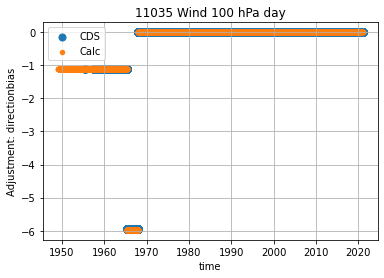

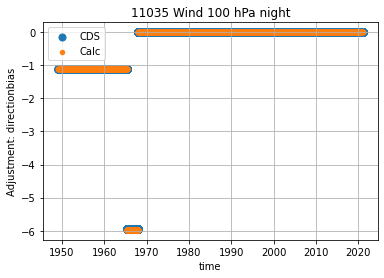

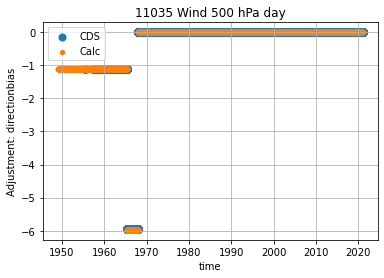

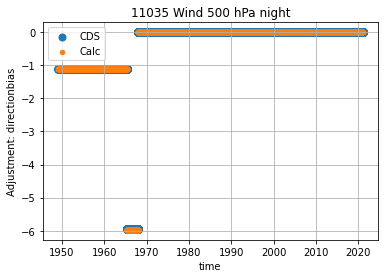

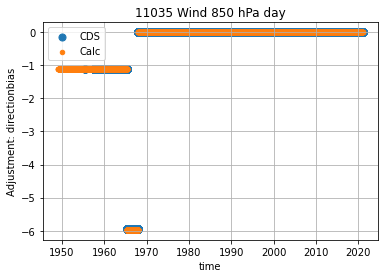

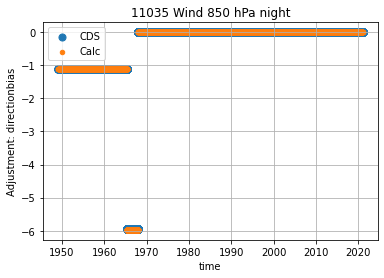

In [18]:
station = '11035'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

2021-05-06 11:05:59,532 INFO Welcome to the CDS
2021-05-06 11:05:59,532 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 11:05:59,897 INFO Request is queued
2021-05-06 11:06:00,935 INFO Request is running
2021-05-06 11:06:04,762 INFO Request is completed
2021-05-06 11:06:04,764 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620291964.3088086-8651-1-4b3456f0-6989-425c-af55-7b9cb2956818.zip to download.zip (27.5M)
2021-05-06 11:06:09,588 INFO Download rate 5.7M/s   
2021-05-06 11:06:10,076 INFO Reading Profile on slice(None, None, None)


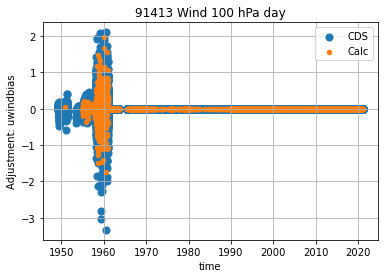

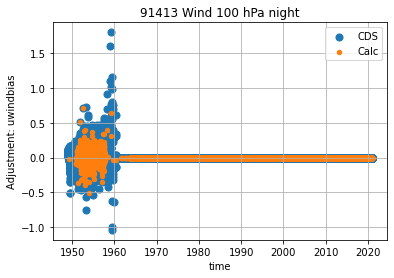

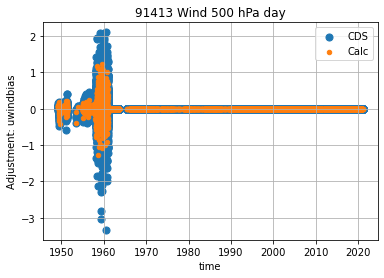

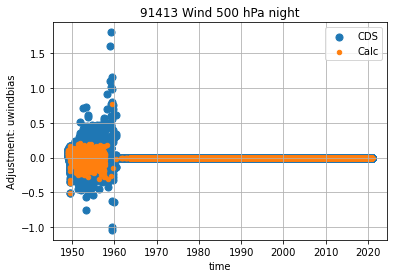

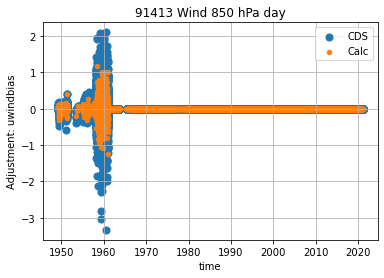

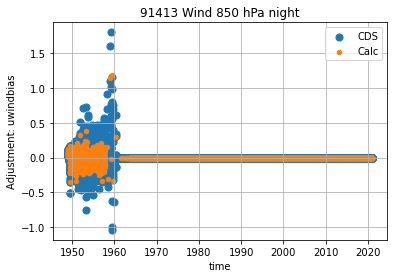

In [19]:
station = '91413'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 11:06:43,699 INFO Welcome to the CDS
2021-05-06 11:06:43,701 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 11:06:44,910 INFO Request is queued
2021-05-06 11:06:45,948 INFO Request is running
2021-05-06 11:06:47,488 INFO Request is completed
2021-05-06 11:06:47,490 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620292006.3071914-8777-1-040ea6ea-221e-400a-819f-63fdb3c4d464.zip to download.zip (27.6M)
2021-05-06 11:06:50,666 INFO Download rate 8.7M/s   
2021-05-06 11:06:51,847 INFO Reading Profile on slice(None, None, None)


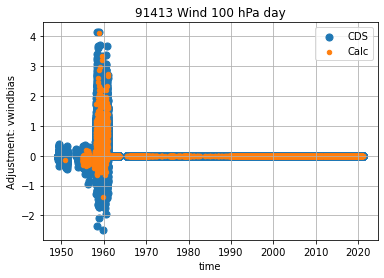

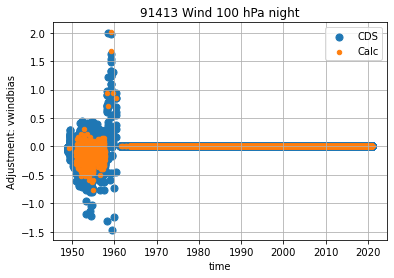

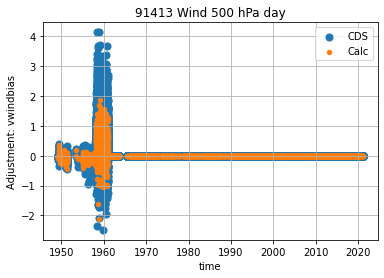

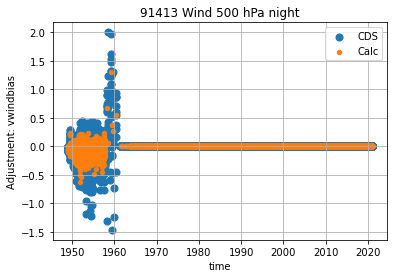

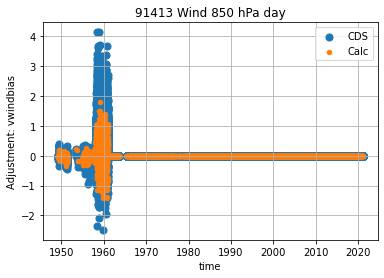

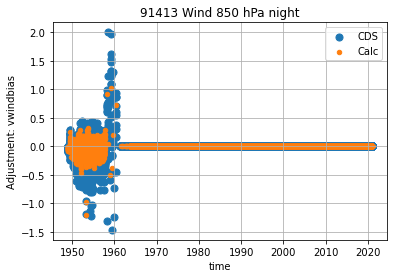

In [20]:
station = '91413'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

2021-05-06 11:07:24,198 INFO Welcome to the CDS
2021-05-06 11:07:24,200 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 11:07:24,421 INFO Request is queued
2021-05-06 11:07:25,464 INFO Request is running
2021-05-06 11:07:27,008 INFO Request is completed
2021-05-06 11:07:27,010 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620292045.8305233-8519-1-893be54a-37b3-407d-950a-35db357f32e1.zip to download.zip (27M)
2021-05-06 11:07:30,207 INFO Download rate 8.4M/s   
2021-05-06 11:07:32,675 INFO Reading Profile on slice(None, None, None)


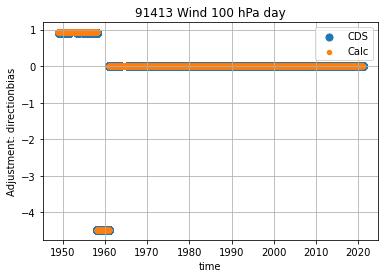

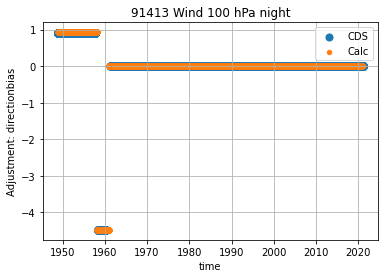

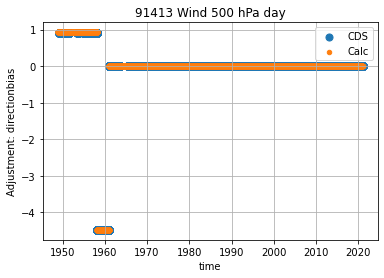

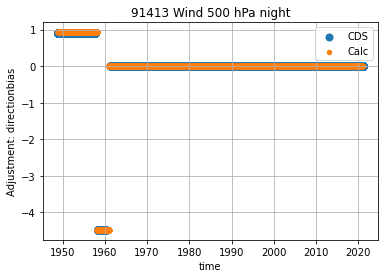

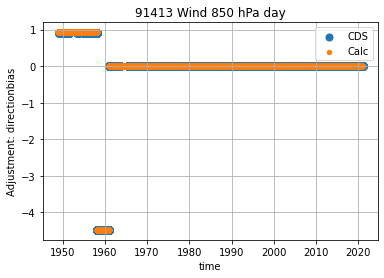

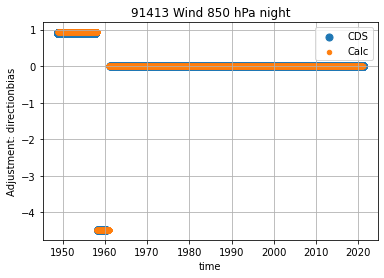

In [21]:
station = '91413'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)